In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
# Load datasets with features
FEATURES_FOLDER = './features'

train_data = np.load(f'{FEATURES_FOLDER}/train_data_128.npy')
test_data = np.load(f'{FEATURES_FOLDER}/test_data_128.npy')
validation_data = np.load(f'{FEATURES_FOLDER}/validation_data_128.npy')

#### OneClassSVM classifier returns 1 as positive result and -1 as negative (outlier).
#### We will train OneClassSVM classifier on every person's train data separately and evaluate that model on all test/validation datasets.

#### How can we measure the performance of  this OneClassSVM model?
* At first, we can check whether selected person's test data yields the biggest number of positive predictions. 
This means that classifier recognizes this person. Thus we will get the number of correctly recognized people.
* At second, we can calculate the next sum: 
$$ \frac{1}{n^2} \sum_{i \in people, \\ j \in people } (pred(i,i) - pred(i,j))^2$$	
where people's set is the set of all people datasets, n - the number of people and $pred(i,j)$ - is average model's prediction of $person_j$ test data when the model is trained on $person_i$ train data. 
We want to maximize this sum.

In [3]:
def get_correct_count(model_results):
    '''
    Diagonal entries correspond to prediction of i's test data on model trained on i's train data.
    If diagonal's value is biggest in a row - model prediction is correct.
    '''
    correct_answers = 0
    
    for index, row in enumerate(model_results):
        if all([row[index]>=item for item in row ]):
            correct_answers += 1
    
    return correct_answers
    

In [4]:
def get_model_score(model_results):
    result = 0
    size = len(model_results)
    
    for index, row in enumerate(model_results):
        result += sum((row[index] - np.array(row))**2)
    
    return result / (size**2)


### Simple OneClassSVM model with rbf kernel

In [5]:
def get_model_results(train, test, kernel='rbf', gamma='scale', nu=0.5):
    '''
    For every person in dataset train and test OneClassSVM model with given params
    '''
    results = [[] for _ in range(15)]

    # Train and test OneClassSVM model for every person
    for person_id in range(15):
        # Fit scaler on train dataset of selected person
        scaler = StandardScaler()
        scaler.fit(train_data[person_id])

        # Rescale every dataset for training/testing
        train_data_scaled = [scaler.transform(df) for df in train]
        test_data_scaled = [scaler.transform(df) for df in test]

        clf = OneClassSVM(gamma=gamma, nu=nu, kernel=kernel)

        # Fit model for one person
        clf.fit(train_data_scaled[person_id])

        # Test model on test datasets of every person
        for pid, person_test_data in enumerate(test_data_scaled):
            prediction = clf.predict(person_test_data)
            probability = sum(prediction==1)/len(prediction)

            results[person_id].append(probability)

    return results
    
model_results = get_model_results(train_data, test_data)

In [6]:
# Visualise results
fig, ax = plt.subplots(figsize=(11,11))         
g = sns.heatmap(model_results, annot=True, square=True, cmap='coolwarm', ax=ax);

correct = get_correct_count(model_results)
score = get_model_score(model_results)
print(f'Correctly classified: {correct}/15, score: {score}')

Correctly classified: 14/15, score: 0.21187862744292582


#### We can see that this model missclasified last person.
#### Let's apply gridsearching method to find the best parameters for OneClassSVM model so that as much people as possible will be correctly classified and with maximum score.

In [9]:
gamma_values = ['auto'] + list(np.linspace(0.01, 1, 20, endpoint=False))
nu_values = list(np.linspace(0.01, 1, 20, endpoint=False))

best_score = 0
best_params = None
best_model_results = [None, None]

for gamma in gamma_values:
    for nu in nu_values:
        model_results = get_model_results(train_data, test_data, 'rbf', gamma, nu)
                
        correct = get_correct_count(model_results)
        # We gather best score only when every person was correctly classified
        if correct == 15:
            score = get_model_score(model_results)
            if score > best_score:
                best_score = score
                best_params = [gamma, nu]
                best_model_results = model_results


print(f'Best score: {best_score}, gamma: {best_params[0]}, nu: {best_params[1]}')

fig, ax = plt.subplots(figsize=(11,11))         
g = sns.heatmap(best_model_results, annot=True, square=True, cmap='coolwarm', ax=ax);

Best score: 0.3554228078927174, gamma: 0.6535000000000001, nu: 0.059500000000000004


#### Evaluate best model on validation dataset

Correctly classified: 14/15, score: 0.3425533099302382, gamma: 0.6535000000000001 nu: 0.059500000000000004


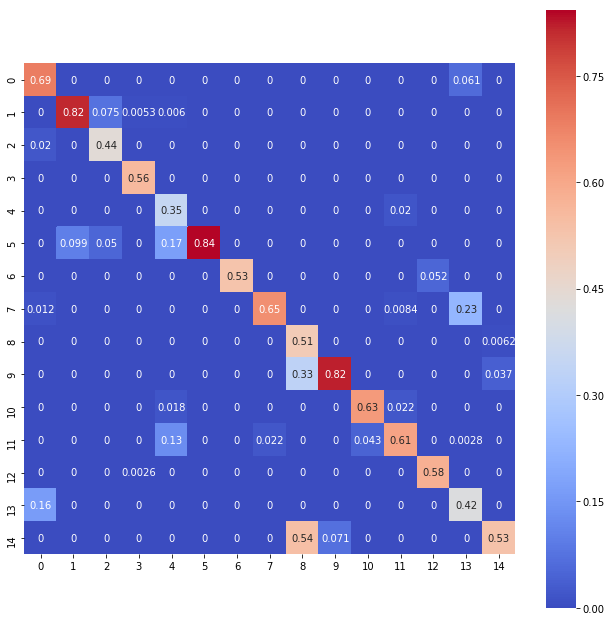

In [10]:
model_results = get_model_results(train_data, validation_data, 'rbf', best_params[0], best_params[1])

# Visualise results
fig, ax = plt.subplots(figsize=(11,11))         
g = sns.heatmap(model_results, annot=True, square=True, cmap='coolwarm', ax=ax);

correct = get_correct_count(model_results)
score = get_model_score(model_results)
print(f'Correctly classified: {correct}/15, score: {score}, gamma: {best_params[0]} nu: {best_params[1]}')

#### Other kernels (poly, sigmoid, linear) were also tested, but they didn't work so good.
#### We received model that correctly classifies  14 out of 15 people in dataset. It still confuses person #15 with person #9, but is very confident about other people.